# Geochemical Facies Analysis

In [214]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
import pylab as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

## Data Import, cleaning and exploration

In [215]:
geochem_df = pd.read_excel('factor_analysis/Geochem_Enthought_02_02_2017.xlsx')
# delete the first row that has units
geochem_df.drop(geochem_df.index[0], inplace=True)

#drop some repeated columns
geochem_df.drop('Well Name', 1, inplace=True)
geochem_df.drop('Stop Depth (ftMD)', 1, inplace=True)
geochem_df.drop('Total', 1, inplace=True)
geochem_df.drop('Sum', 1, inplace=True)

In [216]:
print(geochem_df.shape) #drop empty rows
geochem_df = geochem_df[pd.notnull(geochem_df['Quartz'])]
print(geochem_df.shape)

(498, 84)
(494, 84)


In [217]:
cols = geochem_df.columns.tolist()
# remove whitespace from column names
cols = map(lambda s: s.strip(), cols)
geochem_df.columns = cols
#move 2nd Well name and Depth columns to leftmost
cols.insert(0, cols.pop(cols.index('Well')))
cols.insert(1, cols.pop(cols.index('Depth')))
geochem_df = geochem_df[cols]
print(geochem_df.shape)

(494, 84)


In [218]:
#convert all numeric columns, nan if missing data
for col in  geochem_df.columns[5:]:
    geochem_df[col] = pd.to_numeric(geochem_df[col], errors='coerce')
print(geochem_df.shape)

(494, 84)


In [219]:
#drop all nan columns and rows
geochem_df.dropna(axis=1, how='all', inplace=True)
geochem_df.dropna(axis=0, how='all', inplace=True)
print(geochem_df.shape)

(494, 59)


In [220]:
geochem_df

,Well,Depth,Sample Type,Facies Code,Facies,Quartz,K-Feldspar,Plagioclase,Total Feldspar,Chlorite,...,Sr,Ta,Th,U,V,W,Y,Zn,Zr,Lu
1,Hughes 1H-1918X,11660,Cuttings,19.0,D7,27.558190,0.395184,8.167913,8.563097,5.457426,...,496.644796,1.334292,3.605333,2.003886,NaN,NaN,27.245684,83.808577,201.698178,NaN
2,Hughes 1H-1918X,11690,Cuttings,2.0,A2,42.917287,0.640922,9.633021,10.273943,4.101030,...,412.752751,NaN,2.237793,1.093029,NaN,2.026117,27.641985,58.218172,395.346318,3.663366
3,Hughes 1H-1918X,11720,Cuttings,2.0,A2,44.547738,0.563385,10.072429,10.635814,4.332989,...,430.444932,NaN,2.735080,1.548457,NaN,NaN,27.146609,69.094094,362.698941,2.227723
4,Hughes 1H-1918X,11750,Cuttings,2.0,A2,42.645552,0.375865,9.037936,9.413801,4.024629,...,409.544828,NaN,4.226943,1.821714,NaN,1.575869,28.929963,66.108547,410.104721,2.475248
5,Hughes 1H-1918X,11780,Cuttings,2.0,A2,42.610581,1.261267,8.954202,10.215469,3.661248,...,462.718581,NaN,1.864828,2.550400,NaN,NaN,29.821640,71.120001,401.495652,NaN
6,Hughes 1H-1918X,11810,Cuttings,2.0,A2,40.134195,1.103486,9.936477,11.039963,3.430219,...,455.719476,NaN,3.481011,2.732571,NaN,NaN,29.821640,95.324259,393.781032,2.623762
7,Hughes 1H-1918X,11840,Cuttings,2.0,A2,40.317316,5.203118,7.723244,12.926363,2.796921,...,587.341526,1.158727,2.486437,1.001943,NaN,NaN,22.589149,81.036283,238.035156,5.742574
8,Hughes 1H-1918X,11870,Cuttings,14.0,D2,36.019415,0.081396,8.869430,8.950826,4.005680,...,502.574593,0.526694,2.486437,2.550400,NaN,NaN,29.326264,77.837482,433.360387,2.475248
9,Hughes 1H-1918X,11900,Cuttings,16.0,D4,36.477085,0.255660,8.624007,8.879667,3.988986,...,471.856301,0.573511,2.486437,2.368229,NaN,NaN,29.722565,81.249536,337.654378,2.475248
10,Hughes 1H-1918X,11930,Cuttings,14.0,D2,32.508773,0.413578,8.887683,9.301260,3.923129,...,521.238872,NaN,2.113471,1.275200,NaN,2.026117,28.335512,81.462790,368.512857,2.128713


In [221]:
geochem_df['Well'] = geochem_df['Well'].str.strip()
geochem_df.drop('Sample Type', 1, inplace=True)

geochem_df['Si/Zr'] = geochem_df['SiO2'] / geochem_df['Zr']
geochem_df['Si/Al'] = geochem_df['SiO2'] / geochem_df['Al2O3']
geochem_df['Zr/Al'] = geochem_df['Zr'] / geochem_df['Al2O3']

In [222]:
columns = [u'Well', u'Depth', u'Facies Code', u'Quartz', u'K-Feldspar',
       u'Plagioclase', u'Total Feldspar',
       u'IlliteSmectiteMica', u'Total Clay', u'Calcite', u'Ankerite/Dolomite', u'Total Carbonate',
       u'Pyrite', u'Organics', u'Al2O3', u'SiO2', u'TiO2', 
       u'Fe2O3', u'MnO', u'MgO', u'CaO', u'Na2O', u'K2O',
       u'P2O5', u'SO3', u'Cl', u'Zr', 'Si/Zr', 'Si/Al',
       'Zr/Al'
       ]

geochem_df = geochem_df[columns]

# interpolate remaining missing values
geochem_df = geochem_df.interpolate()

In [223]:
geochem_df

,Well,Depth,Facies Code,Quartz,K-Feldspar,Plagioclase,Total Feldspar,IlliteSmectiteMica,Total Clay,Calcite,...,CaO,Na2O,K2O,P2O5,SO3,Cl,Zr,Si/Zr,Si/Al,Zr/Al
1,Hughes 1H-1918X,11660,19.0,27.558190,0.395184,8.167913,8.563097,20.734070,26.191496,26.109431,...,19.485203,0.782280,1.192401,0.197497,1.203006,0.27550,201.698178,0.209418,5.811836,27.752344
2,Hughes 1H-1918X,11690,2.0,42.917287,0.640922,9.633021,10.273943,15.605936,19.706967,18.313030,...,15.523925,0.926904,1.005338,0.192058,0.808247,0.26470,395.346318,0.126898,9.870668,77.784505
3,Hughes 1H-1918X,11720,2.0,44.547738,0.563385,10.072429,10.635814,15.170980,19.503969,16.782742,...,15.523925,0.874313,0.979329,0.177147,0.757809,0.23050,362.698941,0.129336,9.291465,71.839757
4,Hughes 1H-1918X,11750,2.0,42.645552,0.375865,9.037936,9.413801,14.559154,18.583783,21.274334,...,15.464447,0.867739,1.048352,0.221692,0.963554,0.25680,410.104721,0.117387,9.210900,78.466400
5,Hughes 1H-1918X,11780,2.0,42.610581,1.261267,8.954202,10.215469,15.533044,19.194292,19.767814,...,18.652502,0.815149,1.057355,0.253295,1.156314,0.24470,401.495652,0.113999,9.146188,80.230503
6,Hughes 1H-1918X,11810,2.0,40.134195,1.103486,9.936477,11.039963,14.621931,18.052150,21.548464,...,19.235393,0.834871,1.188399,0.291838,1.268176,0.22990,393.781032,0.116386,7.631634,65.571771
7,Hughes 1H-1918X,11840,2.0,40.317316,5.203118,7.723244,12.926363,10.761529,13.558449,23.804560,...,27.752734,0.624509,1.071360,0.133071,1.195765,0.30170,238.035156,0.164481,7.031265,42.748240
8,Hughes 1H-1918X,11870,14.0,36.019415,0.081396,8.869430,8.950826,14.614197,18.619876,27.364065,...,22.399656,0.749411,1.042350,0.195434,1.308126,0.28190,433.360387,0.100356,8.402742,83.729699
9,Hughes 1H-1918X,11900,16.0,36.477085,0.255660,8.624007,8.879667,16.106384,20.095370,24.099495,...,20.341695,0.661323,1.126378,0.207062,1.250697,0.25780,337.654378,0.117776,8.185590,69.501324
10,Hughes 1H-1918X,11930,14.0,32.508773,0.413578,8.887683,9.301260,13.746146,17.669275,30.562218,...,23.446480,0.762559,1.152387,0.182023,1.293644,0.28280,368.512857,0.115223,7.132140,61.898611


## Dimensionality reduction

-explain the variability in the data
-express the data as a relationship between underlying variables

In [224]:
def pca_summary(pca, standardised_data, out=True):
    names = ["PC"+str(i) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    a = list(np.std(pca.transform(standardised_data), axis=0))
    b = list(pca.explained_variance_ratio_)
    c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    columns = pd.MultiIndex.from_tuples([("sdev", "Standard deviation"), ("varprop", "Proportion of Variance"), ("cumprop", "Cumulative Proportion")])
    summary = pd.DataFrame(zip(a, b, c), index=names, columns=columns)
    if out:
        print("Importance of components:")
        print(summary)
        return summary

def screeplot(pca, standardised_values):
    y = np.std(pca.transform(standardised_values), axis=0)**2
    x = np.arange(len(y)) + 1
    plt.plot(x, y, "o-")
    plt.xticks(x, ["Comp."+str(i) for i in x], rotation=60)
    plt.ylabel("Variance")
    plt.show()

def pca_scatter(pca, standardised_values, classifs):
    comps = pca.transform(standardised_values)
    comp_df = pd.DataFrame(zip(comps[:, 0], comps[:, 1], classifs), columns=["PC1", "PC2", "Well"])
    sns.lmplot("PC1", "PC2", comp_df, hue="Well", fit_reg=False)
    plt.show()

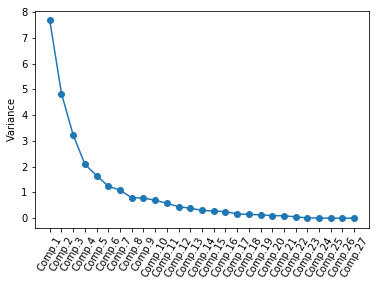

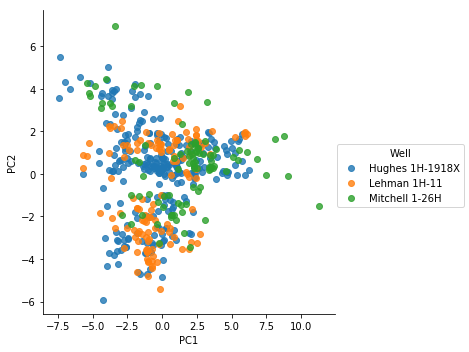

In [225]:
data = geochem_df.ix[:, 3:]
data = scale(data)
pca = PCA()
pca.fit(data)

screeplot(pca, data)

pca_scatter(pca, data, geochem_df['Well'].values)

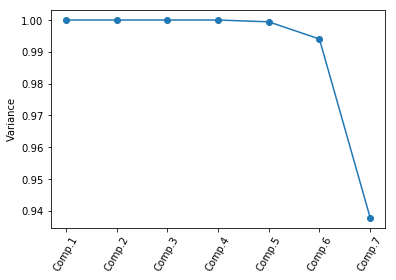

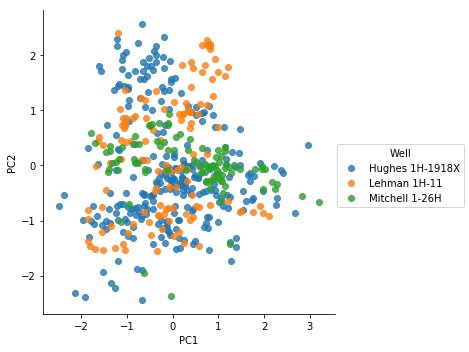

     Quartz    K-Feldspar   Plagioclase  Total Feldspar  IlliteSmectiteMica  \
0 -0.554808 -5.456267e-01 -5.306071e-01   -7.632458e-01           -0.376852   
1  0.414685  4.090484e-01 -8.361598e-01   -5.849623e-01            0.436086   
2  0.063396 -7.303229e-01  9.730193e-02   -2.643397e-01            0.478405   
3  0.004072  3.999132e-02 -9.912184e-02   -7.348189e-02            0.080854   
4 -0.707342  6.922668e-10  2.051887e-10    5.294764e-10            0.647829   
5 -0.033114  7.450330e-12  3.095472e-12    6.530278e-12            0.009981   
6 -0.011721  1.480630e-14 -3.240385e-12   -3.031529e-12            0.015687   

   Total Clay       Calcite  Ankerite/Dolomite  Total Carbonate    Pyrite  \
0   -0.391018  8.782801e-01       3.881837e-01     8.847613e-01  0.002092   
1    0.370418 -2.673172e-01      -4.670941e-01    -3.586651e-01 -0.062495   
2    0.491310 -2.874058e-01      -1.456408e-01    -2.942940e-01 -0.101723   
3    0.081560 -2.730631e-01       7.809772e-01    -4.413434

In [226]:
from sklearn.decomposition import FactorAnalysis

fa = FactorAnalysis(n_components = 7, tol=1e-8, max_iter=1000000)
fa.fit(data)

screeplot(fa, data)

pca_scatter(fa, data, geochem_df['Well'].values)

fa_data = fa.transform(data)

fa_df = pd.DataFrame(fa_data, columns=['Comp {}'.format(i) for i in range(0,7)])
fa_df['Well'] = geochem_df['Well']
fa_df['Depth'] = geochem_df['Depth']
kmeans = KMeans(n_clusters=7, random_state=0).fit(fa_data)

fa_df['FAFacies'] = kmeans.labels_

factors =  pd.DataFrame(fa.components_, columns=geochem_df.ix[:, 3:].columns.values)
print(factors)

At the intersection of each factor and feature, a positive number indicates that a positive proportion exists between the two; a negative number, instead, points out that they diverge and one is the contrary to the other.

We can examine the relationship between factors and the observed features.  A positive number suggests that the observation of a feature is correlated to the presence of an underlying factor.  A negative number suggests the the opposite.    For example, the first factor (Factor 0) is strongly associated with K-Feldspar, Plagioclase, TiO2 and Zirconium

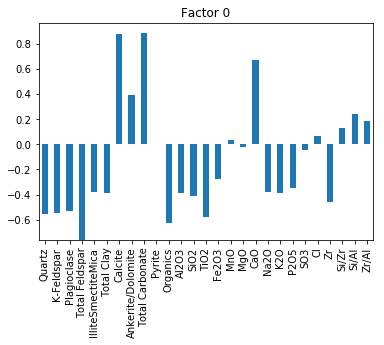

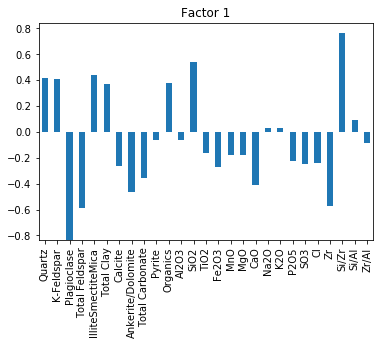

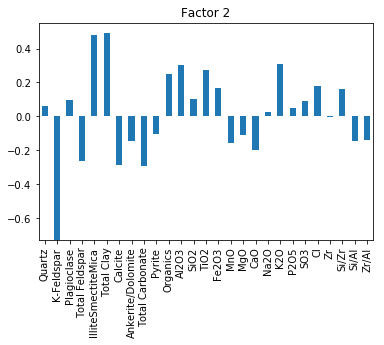

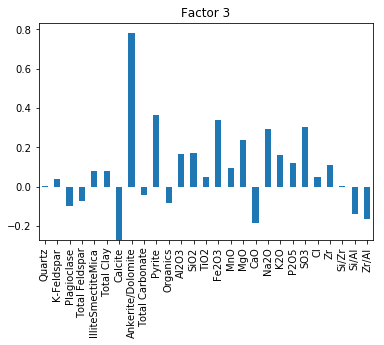

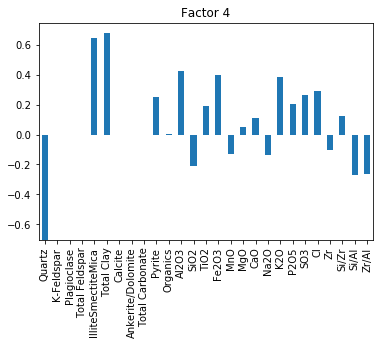

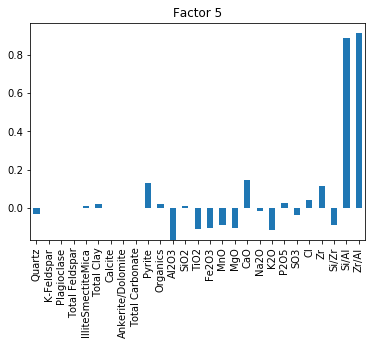

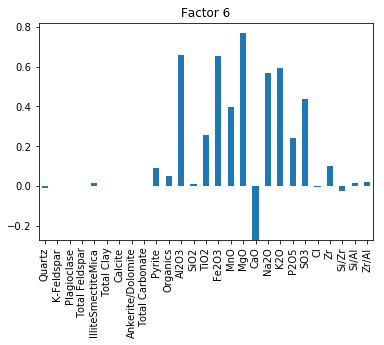

In [227]:
for factor_id in range(0, factors.shape[0]):
    plt.figure()
    plt.title('Factor {}'.format(factor_id))
    factors.ix[factor_id].plot(kind='bar')

In [228]:
comp_data = pca.transform(data)[:,:7]
pca_df = pd.DataFrame(comp_data, columns=['Comp {}'.format(i) for i in range(0,7)])
pca_df['Well'] = geochem_df['Well']
pca_df['Depth'] = geochem_df['Depth']
kmeans = KMeans(n_clusters=7, random_state=0).fit(comp_data)

pca_df['PCAFacies'] = kmeans.labels_

pca_df

,Comp 0,Comp 1,Comp 2,Comp 3,Comp 4,Comp 5,Comp 6,Well,Depth,PCAFacies
0,-1.989166,3.604282,3.113103,-2.288086,2.070599,-1.356634,-0.751606,NaN,NaN,3
1,-2.654676,1.204999,-1.265225,-2.556044,2.078974,-1.422542,-2.025354,Hughes 1H-1918X,11660,3
2,-2.287787,1.093935,-1.421895,-2.674988,1.211750,-0.690149,-2.458581,Hughes 1H-1918X,11690,3
3,-2.675363,1.433789,-1.124536,-2.617169,1.819703,-0.608620,-2.422153,Hughes 1H-1918X,11720,3
4,-2.770994,1.522910,-1.162808,-2.491326,1.954839,-0.765348,-1.810274,Hughes 1H-1918X,11750,3
5,-2.843829,2.789008,-0.792775,-2.314386,1.906014,-1.109572,-1.229215,Hughes 1H-1918X,11780,3
6,-0.639161,2.577742,-0.498588,-1.872986,0.396995,-1.400996,-1.241816,Hughes 1H-1918X,11810,3
7,-1.335629,2.924526,0.010670,-2.805501,2.305787,-1.165605,-1.874910,Hughes 1H-1918X,11840,3
8,-1.626435,2.531024,0.502531,-2.767140,2.016885,-0.955557,-1.163204,Hughes 1H-1918X,11870,3
9,-1.056778,3.650992,0.785317,-2.529341,2.107108,-1.438961,-1.354886,Hughes 1H-1918X,11900,3


# Clustering

In [229]:
geochem_df = pd.read_csv('factor_analysis/geochem_factors.csv')

geochem_df.rename(columns={'Si.Zr':'Si-Zr', 'Al2O3':'Al',
                           'Si.Al': 'Si-Al', 'CaO':'Ca',
                           'Zr.Al':'Zr-Al',
                           'Total.Carbonate':'Total Carbonate',
                           'Total.Feldspar':'Total Feldspar'},
                           inplace=True)

In [230]:
facies_colors = ['#DA9F8A', '#E48C50','#8E8E68','#88A64C',
       '#5FBBB1','#00A7CB', '#3974AA']

In [231]:
def make_facies_log_plot(logs, facies_colors, label):
    #make sure logs are sorted by depth 
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs[label].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs['Zr'], logs.Depth, '-g')
    ax[1].plot(logs['Zr-Al'], logs.Depth, '-')
    ax[2].plot(logs['Si-Al'], logs.Depth, '-', color='0.5')
    ax[3].plot(logs['Al'], logs.Depth, '-', color='r')
    ax[4].plot(logs['Quartz'], logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=6)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((16*' ').join(['Clust 1', 'Clust 2', 'Clust 3', 
                                'Clust 4', 'Clust 5', 'Clust 6', 'Clust 7']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("Zr")
    ax[0].set_xlim(logs['Zr'].min(),logs['Zr'].max())
    ax[1].set_xlabel("Zr/Al")
    ax[1].set_xlim(logs['Zr-Al'].min(),logs['Zr-Al'].max())
    ax[2].set_xlabel("Si/Al")
    ax[2].set_xlim(logs['Si-Al'].min(),logs['Si-Al'].max())
    ax[3].set_xlabel("Al2O3")
    ax[3].set_xlim(logs['Al'].min(),logs['Al'].max())
    ax[4].set_xlabel("Quartz")
    ax[4].set_xlim(logs['Quartz'].min(),logs['Quartz'].max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well'], fontsize=14,y=0.94)
    return f

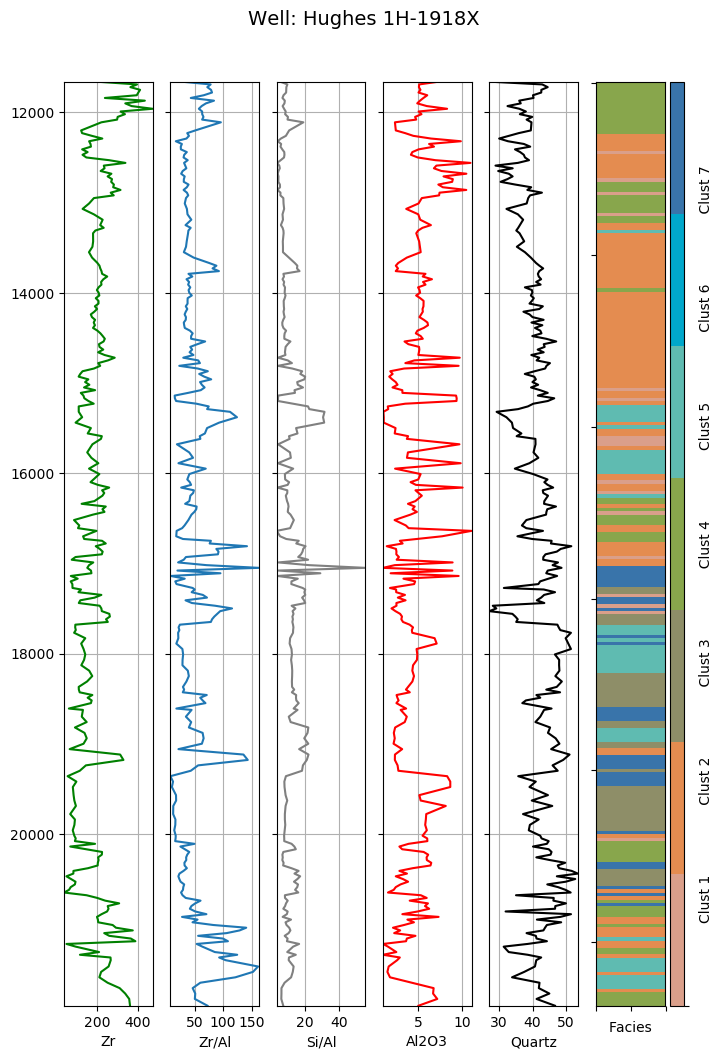

In [232]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

geochem_df['PCAFacies'] = pca_df['PCAFacies']
f = make_facies_log_plot(geochem_df[geochem_df['Well'] == 'Hughes 1H-1918X'],
        facies_colors, 'PCAFacies')


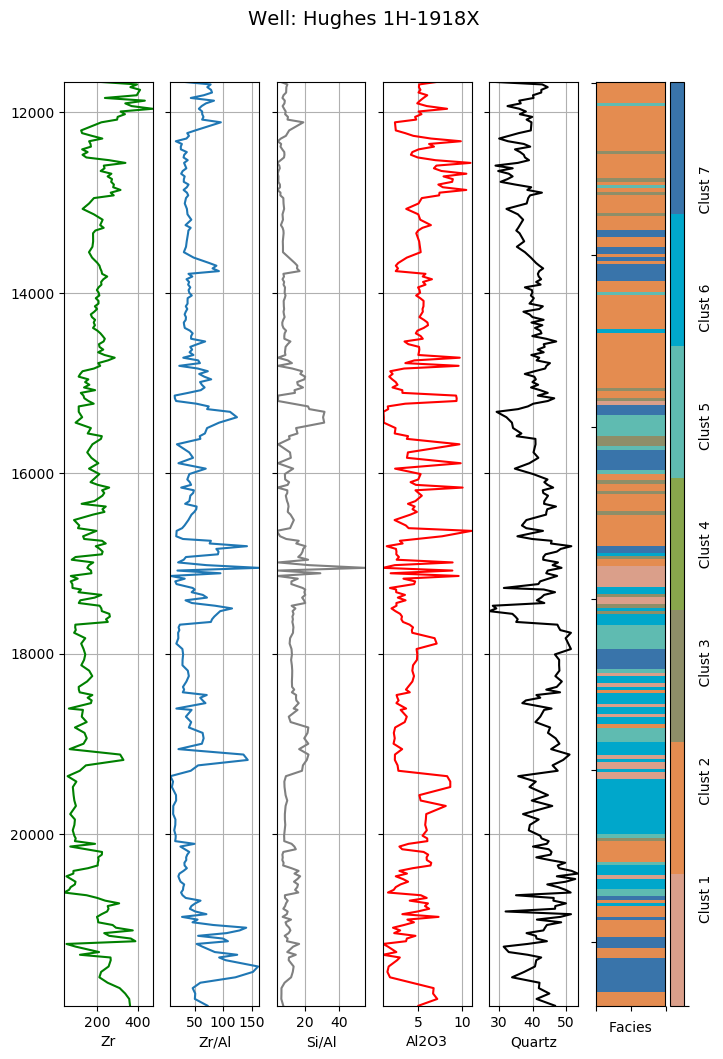

In [233]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

geochem_df['FAFacies'] = fa_df['FAFacies']
f = make_facies_log_plot(geochem_df[geochem_df['Well'] == 'Hughes 1H-1918X'],
        facies_colors, 'FAFacies')


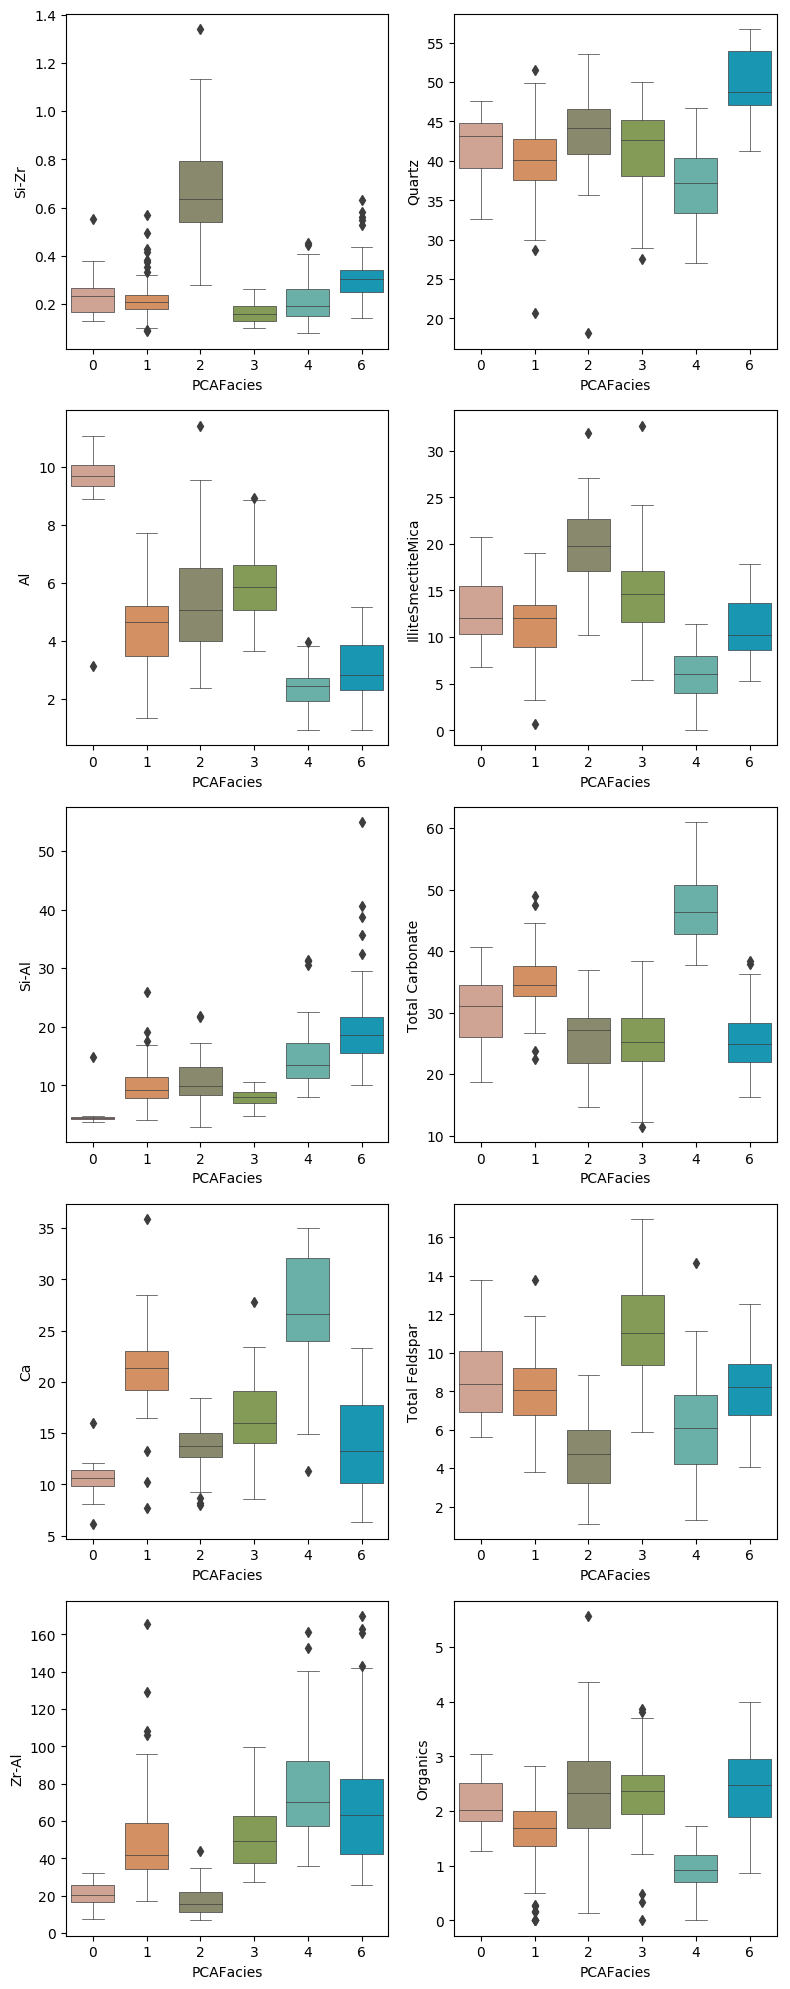

In [234]:
fig, ax = plt.subplots(5,2, figsize=(8,20))
sns.boxplot(x='PCAFacies', y='Si-Zr', linewidth=0.5,
            data=geochem_df, ax=ax[0,0],
            palette=facies_colors)
sns.boxplot(x='PCAFacies', y='Al', linewidth=0.5,
            data=geochem_df,ax=ax[1,0],
            palette=facies_colors)  
sns.boxplot(x='PCAFacies', y='Si-Al', linewidth=0.5,
            data=geochem_df, ax=ax[2,0],
            palette=facies_colors)
sns.boxplot(x='PCAFacies', y='Ca', linewidth=0.5,
            data=geochem_df, ax=ax[3,0],
            palette=facies_colors)
sns.boxplot(x='PCAFacies', y='Zr-Al', linewidth=0.5,
            data=geochem_df, ax=ax[4,0],
            palette=facies_colors)
sns.boxplot(x='PCAFacies', y='Quartz', linewidth=0.5,
            data=geochem_df, ax=ax[0,1],
            palette=facies_colors)
sns.boxplot(x='PCAFacies', y='IlliteSmectiteMica', linewidth=0.5,
            data=geochem_df, ax=ax[1,1],
            palette=facies_colors)
sns.boxplot(x='PCAFacies', y='Total Carbonate', linewidth=0.5,
            data=geochem_df, ax=ax[2,1],
            palette=facies_colors)
sns.boxplot(x='PCAFacies', y='Total Feldspar', linewidth=0.5,
            data=geochem_df, ax=ax[3,1],
            palette=facies_colors)
sns.boxplot(x='PCAFacies', y='Organics', linewidth=0.5,
            data=geochem_df, ax=ax[4,1],
            palette=facies_colors)
plt.tight_layout()

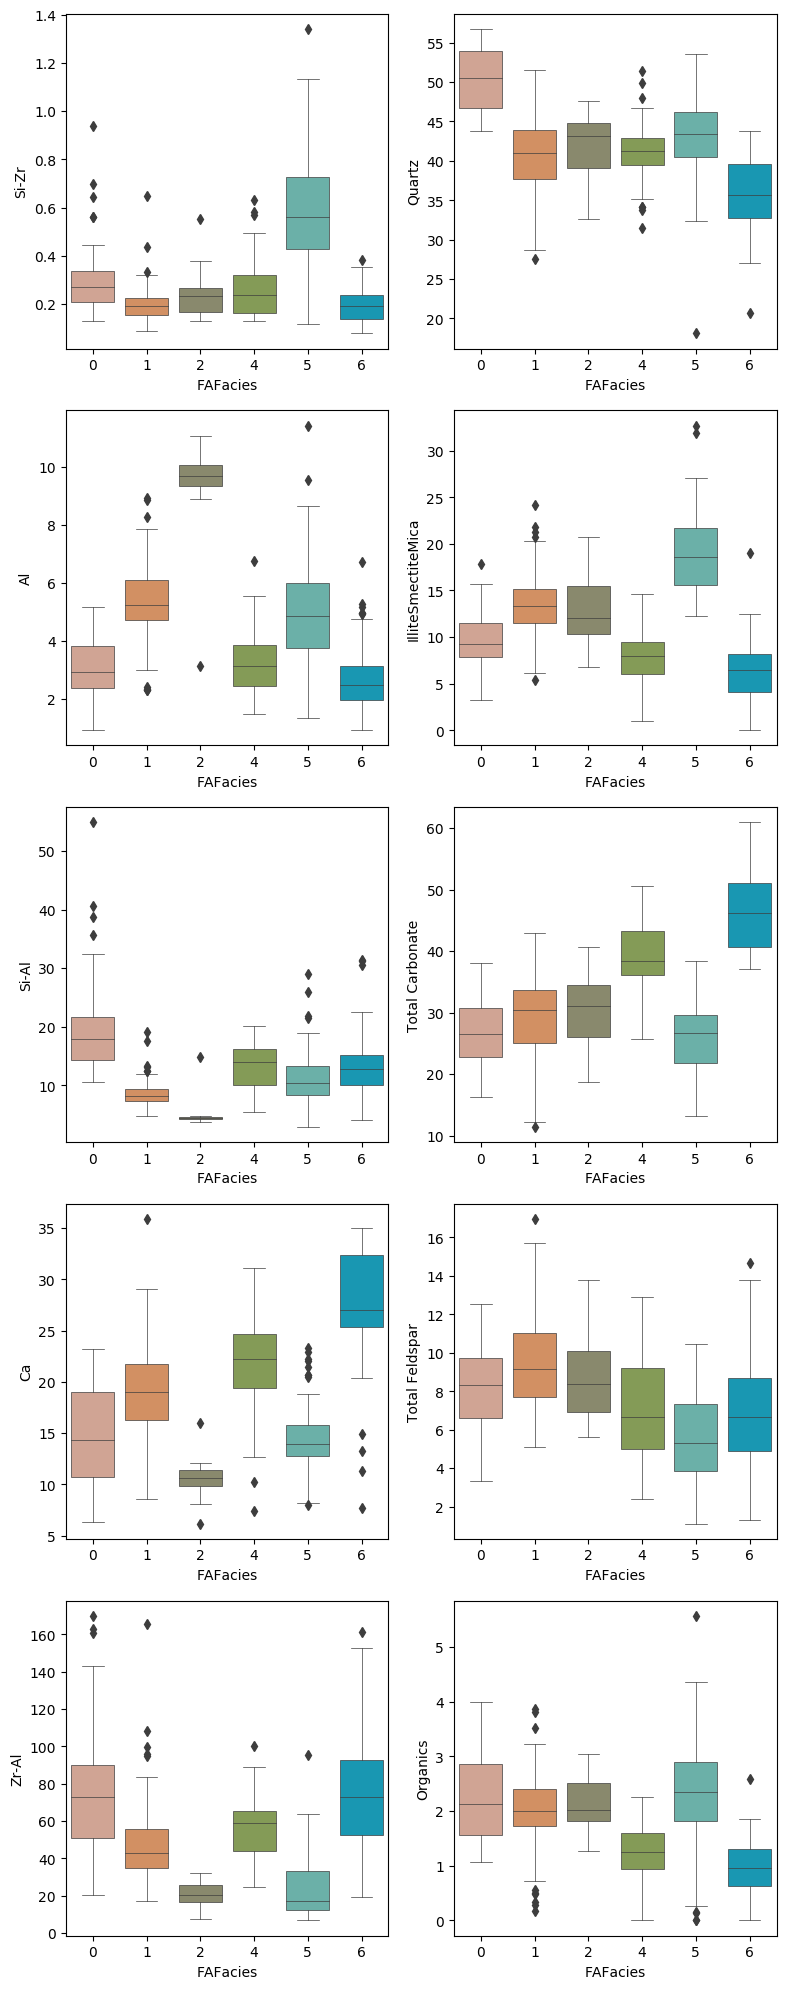

In [235]:
fig, ax = plt.subplots(5,2, figsize=(8,20))
sns.boxplot(x='FAFacies', y='Si-Zr', linewidth=0.5,
            data=geochem_df, ax=ax[0,0],
            palette=facies_colors)
sns.boxplot(x='FAFacies', y='Al', linewidth=0.5,
            data=geochem_df,ax=ax[1,0],
            palette=facies_colors)  
sns.boxplot(x='FAFacies', y='Si-Al', linewidth=0.5,
            data=geochem_df, ax=ax[2,0],
            palette=facies_colors)
sns.boxplot(x='FAFacies', y='Ca', linewidth=0.5,
            data=geochem_df, ax=ax[3,0],
            palette=facies_colors)
sns.boxplot(x='FAFacies', y='Zr-Al', linewidth=0.5,
            data=geochem_df, ax=ax[4,0],
            palette=facies_colors)
sns.boxplot(x='FAFacies', y='Quartz', linewidth=0.5,
            data=geochem_df, ax=ax[0,1],
            palette=facies_colors)
sns.boxplot(x='FAFacies', y='IlliteSmectiteMica', linewidth=0.5,
            data=geochem_df, ax=ax[1,1],
            palette=facies_colors)
sns.boxplot(x='FAFacies', y='Total Carbonate', linewidth=0.5,
            data=geochem_df, ax=ax[2,1],
            palette=facies_colors)
sns.boxplot(x='FAFacies', y='Total Feldspar', linewidth=0.5,
            data=geochem_df, ax=ax[3,1],
            palette=facies_colors)
sns.boxplot(x='FAFacies', y='Organics', linewidth=0.5,
            data=geochem_df, ax=ax[4,1],
            palette=facies_colors)
plt.tight_layout()

In [236]:
filename = 'CG_project/hughes_survey.csv'

hughes_df = pd.read_csv(filename)

In [237]:
# combine the stat facies curve 
filename = 'Hughes_facies.csv'
facies_df = geochem_df[geochem_df['Well'] == 'Hughes 1H-1918X'] # pd.read_csv(filename)

In [238]:
from scipy.interpolate import interp1d, interp2d, RectBivariateSpline
x = hughes_df.MD.values
y = hughes_df.TVD.values
f = interp1d(x,y)
facies_df.loc[:,'TVD'] = f(facies_df.Depth)

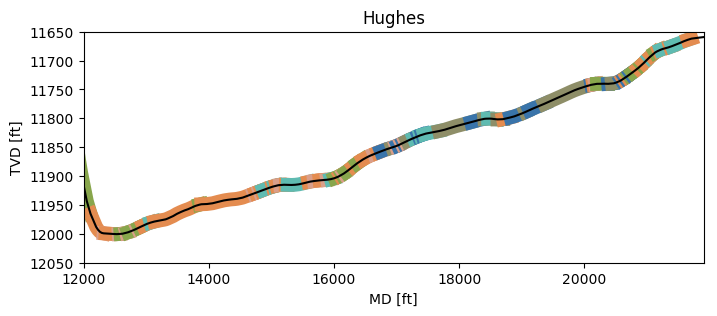

In [239]:
last_row = len(facies_df)
facies_colors = ['#DA9F8A', '#E48C50','#8E8E68','#88A64C',
       '#5FBBB1','#00A7CB', '#3974AA']
plt.figure(figsize=(8,3))

x = []
y = []
for index, row in facies_df.iterrows():
    if index == last_row-1:
        break
    next_row = facies_df.ix[index+1]
    current_facies = row['PCAFacies']
    next_facies = facies_df.ix[index+1, 'PCAFacies']
    #print('current: %d, next: %d\n'%(current_facies, next_facies))
    x.append(row.Depth)
    y.append(row.TVD)
    if current_facies != next_facies:
        x.append(next_row.Depth)
        y.append(next_row.TVD)
        plt.plot(x,y,color=facies_colors[current_facies],linewidth=10)
        x = []
        y = []
plt.xlim([12000, 21905])
plt.ylim([11650, 12050])
plt.gca().invert_yaxis()

plt.plot(facies_df.Depth, facies_df.TVD, color='k',label='Hughes')
plt.title('Hughes')
plt.xlabel('MD [ft]')
plt.ylabel('TVD [ft]')
plt.show()